In [1]:
# Prepate Library Packages for Deep Q learning Network
# Check if this code runs in Colab
RunningInCOLAB = 'google.colab' in str(get_ipython())

# To prevent that some version of matplolib causes an openmp error
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# Check if the code is running in a Colab environment.
if RunningInCOLAB:
    # If in Colab, install necessary packages.
    # Gymnasium is installed with version 0.26.3 along with Box2D dependencies.
    !pip install swig
    !pip install gymnasium==0.26.3
    !pip install gymnasium[box2d]
    !pip install pygame
    !pip install 'moviepy>=1.0.3'
    # Import tqdm for Jupyter Notebooks in Colab.
    from tqdm.notebook import tqdm
else:
    # If not in Colab, import tqdm for other environments.
    from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.9/836.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.9 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2373129 sha256=ebf1ba46246a8fe5a417e7caccdb29c3c43d7df2652dd1bfb246df43ea7a0890
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2


In [3]:
#import library and packages.
import numpy as np  # import numpy for the calculation
import tensorflow as tf   # import tensorflow to simulate the assignments
import matplotlib.pyplot as plt # import matplot to plot the graph

# Import Gymnasium library for reinforcement learning environments.
import gymnasium as gym

# Import Gymnasium wrappers for modifying environments.
from gymnasium import wrappers

# Import deque for creating a double-ended queue (often used in replay memory).
from collections import deque

# Import random for generating random numbers and making random selections.
import random


In [4]:
# Retrieve a list of physical devices (GPUs) available for TensorFlow.
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Try to set memory GPU.
try:
    # if available
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # If no GPU is detected
    print('GPU is not detected or an error occurred during configuration.')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# check the gym version
gym.__version__

'0.26.3'

In [6]:
# select evironment
# Discrete Action Space:    0 for Cartpole, 1 for LunarLander

SELECT_ENV = 0

In [7]:
# Depending on the value of SELECT_ENV, different environments and settings are chosen.
if SELECT_ENV == 0:
    # For SELECT_ENV = 0, set up the CartPole environment.
    env_name, res_prefix = 'CartPole-v1', 'cart'
    max_episodes, max_ep_steps, goal_score = 500, 500, 450
    network_type, state_width, state_height, state_depth = 'dense', 0, 0, 0
    # Set render mode to 'rgb_array'.
    kwargs = {'render_mode': 'rgb_array'}
elif SELECT_ENV == 1:
    # For SELECT_ENV = 1, set up the LunarLander environment.
    env_name, res_prefix = 'LunarLander-v2', 'lunD'
    max_episodes, max_ep_steps, goal_score = 500, 1000, 200
    network_type, state_width, state_height, state_depth = 'dense', 0, 0, 0
    # Set continuous mode to False and render mode to 'rgb_array'.
    kwargs = {'continuous': False, 'render_mode': 'rgb_array'}
else:
    # if an incorrect environment selection is made, raise an error
    assert False, 'environment selection error'

# Function to create the selected environment with the specified settings.
def create_env():
    # create the Gym environment with the specified name and additional keyword arguments.
    env = gym.make(env_name, **kwargs)
    return env


In [8]:
# Define the functions to reset and performs an acitons
# Function that resets the environment to its initial state
def env_reset(env):
    observation = env.reset()
    state = observation[0] if type(observation)==tuple else observation
    return state
# Function that performs an action in the environment and retrieves relevant information.
def env_step(env, action):
    observation = env.step(action)
    state = observation[0]
    reward = observation[1]
    done = observation[2] or observation[3] if len(observation)>4 else observation[2]
    return state, reward, done

In [9]:
# create and update the variables
# Create the Gym environment
env = create_env()
# Reset the environment and obtain the initial state.
state = env_reset(env)
# Retrieve the updated state, reward, and termination information after taking the action.
state, reward, done = env_step(env, env.action_space.sample())

In [10]:
# Obtain information about the action space and its characteristics.
action_shape = env.action_space.shape
action_space_type = type(env.action_space)

# Check the type of action space and set relevant properties accordingly.
if action_space_type == gym.spaces.discrete.Discrete:
    actn_space = 'DISCRETE'
    action_shape = (1,)  # Shape of the action space for discrete actions
    action_dims = 1
    action_range = env.action_space.n  # Number of discrete actions available
    num_actions = action_range  # Number of actions equals action range for DISCRETE actions
    action_batch_shape = (None, action_range)  # Batch shape for action space
elif action_space_type == gym.spaces.box.Box:
    actn_space = 'CONTINUOUS'
    action_dims = action_shape[0]  # Dimensions of the action space for continuous actions
    actn_uppr_bound = env.action_space.high[0]  # Upper bounds of the continuous action space
    actn_lowr_bound = env.action_space.low[0]  # Lower bounds of the continuous action space
    action_range = (actn_uppr_bound - actn_lowr_bound)  # Range of the continuous action space
    action_batch_shape = tuple([None] + [x for x in action_shape])  # Batch shape for action space
    num_actions = action_dims  # Number of actions equals action dimension for CONTINUOUS actions
else:
    # Raise an assertion error if an unsupported action space type is encountered.
    assert False, 'other action space types are not supported'

# Obtain information about the observation space and its characteristics.
observation_space_type = type(env.observation_space)
observation_shape = env.observation_space.shape

# Check the type of observation space and set relevant properties accordingly.
if observation_space_type == gym.spaces.discrete.Discrete:
    observation_shape = (1,)
    num_states = env.observation_space.n  # Number of discrete states available
elif observation_space_type == gym.spaces.box.Box:
    num_states = observation_shape[0]  # Dimensions of the observation space for continuous states
else:
    print('observation space type error')  # Print an error message for unsupported observation space types

# Set state shape and batch shape based on the selected environment type.
if SELECT_ENV == 2 or SELECT_ENV == 3 or SELECT_ENV == 4 or SELECT_ENV == 7:
    state_shape = (96, 96, 3)  # Define the state shape for specific environments
    state_batch_shape = (None, 96, 96, 3)  # Define the batch shape for state for specific environments
else:
    state_shape = observation_shape  # Use observation shape as state shape for other environments
    state_batch_shape = tuple([None] + [x for x in observation_shape])  # Define state batch shape

value_shape = (1,)  # Define the shape of the value function output
num_values = 1  # Define the number of values (commonly used in value-based algorithms)


In [11]:
# print the information
print('Action space ', action_space_type)
print('Action shape ', action_shape)
print('Action dimensions ', action_dims)
print('Action range ', action_range)
if action_space_type==gym.spaces.box.Box:
    print('Max Value of Action ', actn_uppr_bound)
    print('Min Value of Action ', actn_lowr_bound)
else: pass
print('Action batch shape ', action_batch_shape)

print('Observation space ', observation_space_type)
print('Observation shape ', observation_shape)
print('Size of State Space ', num_states)
print('State shape ', state_shape)
print('State batch shape ', state_batch_shape)

print('Vallue shape ', value_shape)
print('Value dimensions ', num_values)

Action space  <class 'gymnasium.spaces.discrete.Discrete'>
Action shape  (1,)
Action dimensions  1
Action range  2
Action batch shape  (None, 2)
Observation space  <class 'gymnasium.spaces.box.Box'>
Observation shape  (4,)
Size of State Space  4
State shape  (4,)
State batch shape  (None, 4)
Vallue shape  (1,)
Value dimensions  1


In [12]:
# Define the DQNet function with the parameter and define the layers and build
def DQNet(hiddens, act_fn, out_fn, init_fn):    # hiddends = (layer1 units, layer2 units)
    inputs = tf.keras.Input(shape=state_shape)  # input layer

    ### START CODE HERE ###
    # Define the architecture with specified hidden layers and activation functions.
    l1 = tf.keras.layers.Dense(units=hiddens[0], activation=act_fn, kernel_initializer=init_fn)(inputs)  # first fully connected layer
    l2 = tf.keras.layers.Dense(units=hiddens[1], activation=act_fn, kernel_initializer=init_fn)(l1)  # second fully connected layer
    # Define the output layer for estimating Q-values for each action.
    outputs = tf.keras.layers.Dense(units=num_actions, activation=out_fn, kernel_initializer=init_fn)(l2)  # output (third) layer

    ###  END CODE HERE  ###
    # Create the Keras Model using input and output layers and name it 'q_net'.
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='q_net')
    return model

# Create a DQN model with default configuration.
def build_DQNet():
    model = DQNet(hiddens=(32,32), act_fn='relu', out_fn='linear', init_fn='he_uniform')
    return model

In [13]:
# Define policy functions
class Agent_Net:
    def __init__(self): # Initialize policy and target networks by building DQN models
        self.policy_q = build_DQNet()             # Build policy network
        self.target_q = build_DQNet()             # Build target network
        self.target_update()                      # Copy weights from policy to target

    def policy(self, state, epsilon, exploring):  # E-greedy policy if exploring==True
        state_input = tf.convert_to_tensor(state[None, ...], dtype=tf.float32)  # Make the state network-ready

        if exploring:                            # If in exploration mode
            if tf.random.uniform(()) > epsilon:  # Exploit if random > epsilon
                action_q = self.policy_q(state_input)[0]
                action = tf.argmax(action_q).numpy()  # Find action for maximum Q-value
            else:                                # Explore else
                action = np.random.randint(num_actions)  # Random action
        else:                                   # If exploiting (greedy policy)
            action_q = self.policy_q(state_input)[0]
            action = tf.argmax(action_q).numpy()  # Find action for maximum Q-value

        return action

    def target_update(self):
        self.target_q.set_weights(self.policy_q.get_weights())  # Copy weights from policy network to target network


In [14]:
# Create an instance of the Agent_Net class
agent = Agent_Net()
# Call the summary() method on the policy_q network to display a summary of its architecture.
agent.policy_q.summary()

Model: "q_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1282 (5.01 KB)
Trainable params: 1282 (5.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Define and Initialize replay memory
class ReplayMemory:
    def __init__(self, memory_size):  # Initialize replay memory using deque with a maximum size
        self.experiences = deque(maxlen=memory_size)    # allocate replay memory
        self.num_episodes = 0                           # Initialize the number of episodes to zero

    def put_experience(self, experience):               # put an experience into replay memory
        state, action, next_state, reward, not_done = experience
        self.experiences.append((state, action, next_state, reward, not_done))
        return

    def get_batch(self, num_samples):                   # get a batch of randomly sampled experiences
        state_batch, next_state_batch, action_batch, reward_batch, not_done_batch = [], [], [], [], []
        # Randomly sample a batch of experiences from the replay memory
        sample_batch = random.sample(self.experiences, num_samples)
        # Iterate through the sample for each experience component (batches)
        for sample in sample_batch:
            state, action, next_state, reward, not_done = sample
            state_batch.append(state)
            action_batch.append(action)
            next_state_batch.append(next_state)
            reward_batch.append(reward)
            not_done_batch.append(not_done)
        # Convert the lists into TensorFlow tensors and create a batch tuple
        batch = (tf.convert_to_tensor(state_batch, dtype=tf.float32),
                tf.convert_to_tensor(action_batch, dtype=tf.int32),
                tf.convert_to_tensor(next_state_batch, dtype=tf.float32),
                tf.convert_to_tensor(reward_batch, dtype=tf.float32),
                tf.convert_to_tensor(not_done_batch, dtype=tf.float32))
        return batch

In [16]:
# define the function to initialize the memory
def init_memory(mem, env, agent, num_samples):
    state = env_reset(env)  # initialize the environment
    for _ in range(num_samples):

        ### START CODE HERE ###

        action = agent.policy(state, epsilon=0.1, exploring=True)  # get an action with the policy
        next_state, reward, done = env_step(env, action)  # observe the environment reaction
        experience = (state, action, next_state, reward, not done)  # pack observations into an experience tuple
        mem.put_experience(experience)  # put the experience into replay memory
        if done:
            state = env_reset(env)  # if episode is done, reset the environment
        else:
            state = next_state  # else, go to the next state

        ###  END CODE HERE  ###

    return



In [17]:
# define one step of training loop
def dqn_train(agent, batch, config):
    state_b, action_b, next_state_b, reward_b, not_done_b = batch

    ### START CODE HERE ###

    curr_q = agent.policy_q(state_b).numpy()  # get Q-values for current states using the policy network (b, a)
    next_q = agent.target_q(next_state_b).numpy()  # get Q-values for next states using the target network (b, a)
    max_next_q = np.max(next_q, axis=1)  # find the maximum Q-value for each next state (b,)

    gamma = getattr(config, 'gamma', 0.99)  # access the gamma value from config (default to 0.99 if not found)
    target_reward = reward_b + gamma * max_next_q * not_done_b  # calculate target Q-value (b,)

    action_v = tf.one_hot(action_b, depth=getattr(config, 'num_actions', 0))  # one-hot encode actions (b, a)
    label_q = curr_q.copy()  # make a copy of the current Q-values for loss calculation
    label_q[np.arange(label_q.shape[0]), action_b] = target_reward  # update Q-value for taken action with target reward

    logs = agent.policy_q.fit(state_b, label_q, verbose=0)  # train the policy network using the batch, suppressing verbosity

    ###  END CODE HERE  ###

    loss = logs.history['loss'][-1]
    return loss


In [18]:
# define the evaluation function for policy
def evaluate_policy(env, agent, num_avg):
    total_reward = 0.0  # Initialize total reward across episodes
    episodes_to_play = num_avg  # Number of episodes to play for averaging
    for i in range(episodes_to_play):  # Play n episodes and take the average
        state = env_reset(env)  # Reset the environment to start a new episode
        done = False  # Flag to denote episode completion
        episode_reward = 0.0  # Initialize reward accumulated within an episode

        while not done:
            # Get an action with the policy
            action = agent.policy(state, epsilon=0.0, exploring=False)

            # Take action and observe outcomes
            next_state, reward, done = env_step(env, action)

            state = next_state  # Update the state for the next step
            episode_reward += reward  # Accumulate the reward obtained
        total_reward += episode_reward  # Accumulate the total reward across episodes
    average_reward = total_reward / episodes_to_play  # Calculate the average reward per episode

    return average_reward


In [19]:
# Exploration parameters for epsilon greedy strategy
class Epsilon:
    def __init__(self, max_steps):
        self.explore_start = 1.0            # exploration probability at start
        self.explore_stop = 0.01            # minimum exploration probability
        self.decay_rate = 20.0/max_steps    # exponential decay rate for exploration prob (4.6 ~ max_step)
        self.steps = 0

    def get_epsilon(self):
        eps = (self.explore_stop
            + (self.explore_start - self.explore_stop) * tf.math.exp(-self.decay_rate * self.steps))
        self.steps += 1
        return eps

In [20]:
# Define and Initializle hyperparameters
class configuration:
    def __init__(self):
        self.gamma = 0.99   # discount rate
        self.lr = 1e-3      # learning rate

config = configuration()

In [21]:
# Set the parameters
max_episodes = 500
max_steps = 30000
batch_size = 128

memory_size = 2000

memD = ReplayMemory(memory_size)
init_memory(memD, env, agent, 1000)
epsF = Epsilon(max_steps)

agent.policy_q.compile(optimizer=tf.optimizers.Adam(learning_rate=config.lr), loss='mse')

In [22]:
# define main training loop
logs = tf.keras.callbacks.History()
logs.history.update({'pi_loss':[]})
logs.history.update({'ereward':[]})
logs.history.update({'e-steps':[]})
logs.history.update({'vreward':[]})

# variables for simulation
num_episodes = 0
val_episodes = 5            # exit condition

# variables for episode logging
pi_loss = 0.0

loss_sum = 0.0
epis_steps = 0
epis_reward = 0.0
eval_reward = -float('inf')

# initialize training variables
epsilon = 1.0
next_state = None
done = True

pbar = tqdm(range(max_steps), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')

for sim_steps in pbar:

    state = env_reset(env) if done else next_state  # get the current state
    action = agent.policy(state, epsilon, exploring=True)  # find an action with epsilon-greedy
    next_state, reward, done = env_step(env, action)  # take action and observe outcomes

    experience = (state, action, next_state, reward, not done)  # pack observations into a new experience
    memD.put_experience(experience)  # put a new experience to replay buffer

    batch = memD.get_batch(batch_size)  # get a new batch from replay buffer
    step_pi_loss = dqn_train(agent, batch, config)  # train DQN for a step

    epsilon = epsF.get_epsilon()  # update decay epsilon value

    loss_sum += step_pi_loss  # accumulate policy loss for a step
    epis_reward += reward  # accumulate reward for a step
    epis_steps += 1  # increase the number of steps for an episode

    if done:
        agent.target_update()  # update target network whenever episode ends
        memD.num_episodes += 1  # increase number of episodes simulated

        pi_loss = loss_sum / epis_steps  # average policy loss for an episode

        pbar.set_postfix({'episode': num_episodes, 'loss': step_pi_loss, 'reward': eval_reward, 'steps': epis_steps, 'evaluating': val_episodes})
        eval_reward = evaluate_policy(env, agent, 1)  # evaluate policy one time

        logs.history['pi_loss'].extend([pi_loss])
        logs.history['ereward'].extend([epis_reward])
        logs.history['e-steps'].extend([epis_steps])
        logs.history['vreward'].extend([eval_reward])

        loss_sum = 0.0
        epis_reward = 0.0
        epis_steps = 0
        num_episodes += 1
    else:
        pass

    pbar.set_postfix({'episode': num_episodes, 'loss': step_pi_loss, 'reward': eval_reward, 'steps': epis_steps})

    # conditions to stop simulation
    if eval_reward > goal_score:
        eval_reward = evaluate_policy(env, agent, val_episodes)  # evaluate policy multiple times
    if eval_reward > goal_score:
        break
    if num_episodes > max_episodes:
        break

print('episodes:{0:5d}, loss:{1:7.5f}, val_reward {2:4.2f}'.format(num_episodes, pi_loss, eval_reward))
print('total steps:', sim_steps+1)


  0%|          | 0/30000 [00:00<?, ?it/s]

episodes:   42, loss:1.42750, val_reward 470.80
total steps: 5519


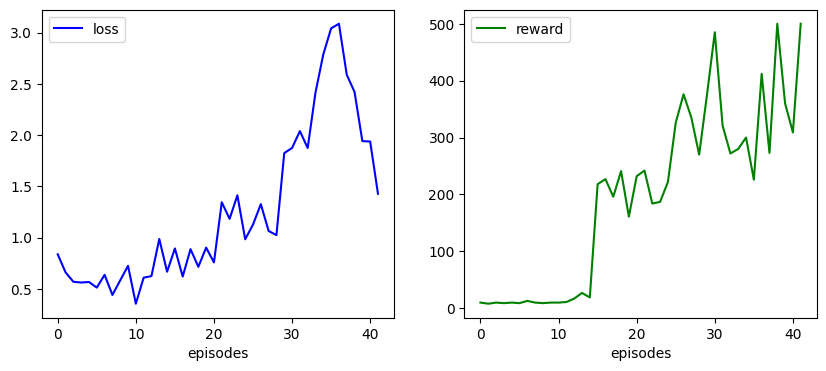

In [23]:
# plot loss and accuracy
def plot_graphs(log_history, log_labels, graph_labels, graph_colors=['b-','g-']):
    num_graphs = len(log_labels)
    plt.figure(figsize=(5*num_graphs,4))
    for i in range(num_graphs):
        plt.subplot(1,num_graphs,i+1)
        plt.plot(log_history[log_labels[i]], graph_colors[i], label=graph_labels[i])
        plt.xlabel('episodes')
        plt.legend()
    plt.show()
    return

log_labels    = ['pi_loss', 'vreward']
label_strings = ['loss', 'reward']
label_colors  = ['b-', 'g-']
plot_graphs(logs.history, log_labels, label_strings, label_colors)

In [24]:
# Evaluate the Agent
evaluate_episodes = 20
sum_episode_rewards = 0.0
pbar = tqdm(range(evaluate_episodes))

for i in pbar:
    sum_episode_rewards += evaluate_policy(env, agent, 1)

print('Evaluation Result:',  sum_episode_rewards/evaluate_episodes)

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation Result: 459.6


In [25]:
# Show how the agent works
env.close()

env = create_env()
env = wrappers.RecordVideo(env, video_folder='./gym-results/', name_prefix=res_prefix)

eval_reward = evaluate_policy(env, agent, 1)

print('Sample Total Reward:', eval_reward)

env.close()

Moviepy - Building video /content/gym-results/cart-episode-0.mp4.
Moviepy - Writing video /content/gym-results/cart-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/gym-results/cart-episode-0.mp4
Sample Total Reward: 500.0


In [26]:
# play the game
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 320):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video('./gym-results/' + res_prefix + '-episode-0.mp4')